# Solar Radiation Prediction Models

This notebook contains a number of methods for predicting the incoming solar radiation at a particular site.  It covers some statistical and machine learning based methods, including Trigonometric Box-Cox, Autoregrssive moving-average with Trend and Seasonality (TBATS) and LSTM-based deep learning models (via Tensorflow).

## Motivation

The motivation for this project came from my work at the Wireless Sensor Networks (WiSe-Net) Laboratory at the University of Maine.  Our goal was to predict the incoming radiation on a solar panel based on past measurements in order to improve the preformance of wireless sensors that depend on solar power.  There are other applications of these methods, for example in predicting the generated solar power from a solar powered array.

Our ideal model would be small enough to run on a microcontroller (a very small processor) rather than a smartphone, computer, or the cloud.  This means skewing our models to be a small as possible; in fact, we are checking whether the LSTM model is feasible in-situ.  In order for the model to be worth the power cost of running the model, it needs to be accurate enough to increase preformance over the baseline without a prediction.  That is the next phase of our research.

## Data and Models

Let's get started by importing a lot of packages.  I will be using numpy, pandas, some plotting libraries, TensorFlow, some utilities (datetime, etc.), tbats, and sktime (an sklearn-like time-series analysis package)

In [36]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#import tensorboard
#%load_ext tensorboard
#import tensorboardcolab
#from tensorboardcolab import TensorBoardColab,TensorBoardColabCallback
#import lightgbm as lgb

from datetime import datetime
from packaging import version

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformers.single_series.detrend import ConditionalDeseasonalizer, Deseasonalizer
from sktime.forecasting.arima import AutoARIMA
from sktime.regression import TimeSeriesForestRegressor
#from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from tbats import TBATS
#plt.style.use('dark_b')

from statsmodels.tsa.stattools import adfuller



## The Data

Let's start with downloading the data.  Since the sensor suite we are developing will be used for forest health monitoring, we will be using solar radiation from the Hubbard Brook Experiemental Forest in Massachusetts.  This should give us a pretty good idea of what to expect in the forest conditions. 

In order to use the data, we download it and load it in a Pandas DataFrame.  This cell of the notebook is available from Hubbard Brook's website, and was not written by me (though everything else was, but why re-invent the wheel?)

In [19]:
# Package ID: knb-lter-hbr.237.1 Cataloging System:https://pasta.edirepository.org.
# Data set title: Hubbard Brook Experimental Forest: 15 Minute Solar Radiation Measurements, 2014 - present.
# Data set creator:   USDA Forest Service, Northern Research Station -  
# Contact:    - Information Manager Hubbard Brook Ecosystem Study  - hbr-im@lternet.edu
# Stylesheet v1.0 for metadata conversion into program: John H. Porter, Univ. Virginia, jporter@virginia.edu      
# 
# This program creates numbered PANDA dataframes named dt1,dt2,dt3...,
# one for each data table in the dataset. It also provides some basic
# summaries of their contents. NumPy and Pandas modules need to be installed
# for the program to run. 


infile1  ="https://pasta.lternet.edu/package/data/eml/knb-lter-hbr/237/1/e4cb501c7d42fd5706e24fca91af4445".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1 
          ,skiprows=1
            ,sep=","  
                ,quotechar='"' 
           , names=[
                    "Date",     
                    "SolRad1",     
                    "SolRad2"    ]
# data type checking is commented out because it may cause data
# loads to fail if the data contains inconsistent values. Uncomment 
# the following lines to enable data type checking
         
#            ,dtype={ 
#             'Date':'str' , 
#             'SolRad1':'float' , 
#             'SolRad2':'float'  
#        }
          ,parse_dates=[
                        'Date',
                ] 
    )
# Coerce the data into the types specified in the metadata 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
dt1=dt1.assign(Date_datetime=pd.to_datetime(dt1.Date,errors='coerce')) 
dt1.SolRad1=pd.to_numeric(dt1.SolRad1,errors='coerce') 
dt1.SolRad2=pd.to_numeric(dt1.SolRad2,errors='coerce') 
      
print("Here is a description of the data frame dt1 and number of lines\n")
print(dt1.info())
print("--------------------\n\n")                
print("Here is a summary of numerical variables in the data frame dt1\n")
print(dt1.describe())
print("--------------------\n\n")                
                         

                    
                    
                 

infile2  ="https://pasta.lternet.edu/package/data/eml/knb-lter-hbr/237/1/fe1bf735842ffdd9728104e6ab2f07dd".strip() 
infile2  = infile2.replace("https://","http://")
                 
dt2 =pd.read_csv(infile2 
          ,skiprows=1
            ,sep=","  
                ,quotechar='"' 
           , names=[
                    "Date",     
                    "SolRad"    ]
# data type checking is commented out because it may cause data
# loads to fail if the data contains inconsistent values. Uncomment 
# the following lines to enable data type checking
         
#            ,dtype={ 
#             'Date':'str' , 
#             'SolRad':'float'  
#        }
          ,parse_dates=[
                        'Date',
                ] 
    )
# Coerce the data into the types specified in the metadata 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
dt2=dt2.assign(Date_datetime=pd.to_datetime(dt2.Date,errors='coerce')) 
dt2.SolRad=pd.to_numeric(dt2.SolRad,errors='coerce') 
      
print("Here is a description of the data frame dt2 and number of lines\n")
print(dt2.info())
print("--------------------\n\n")                
print("Here is a summary of numerical variables in the data frame dt2\n")
print(dt2.describe())
print("--------------------\n\n")           


                    
                    
                






Here is a description of the data frame dt1 and number of lines

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164833 entries, 0 to 164832
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           164833 non-null  datetime64[ns]
 1   SolRad1        164833 non-null  float64       
 2   SolRad2        164833 non-null  float64       
 3   Date_datetime  164833 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 5.0 MB
None
--------------------


Here is a summary of numerical variables in the data frame dt1

             SolRad1        SolRad2
count  164833.000000  164833.000000
mean      119.483206     119.809603
std       220.774879     221.288786
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.838000       1.863000
75%       115.800000     116.100000
max      1128.000000    1130.000000
--------------------


Here is a descr

Let's See what we are working with!

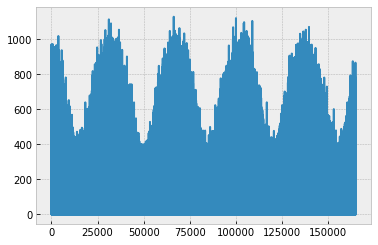

In [20]:
plt.plot(dt1['SolRad1'])
plt.show()


It looks like a stationary time series with a lot of seasonality.  Let's investigate that, and then fit some models.  I would guess that there are daily trends (no sun at night) and annual trends (less in Winter, more in summer).  

In order to investigate this, we use the Dickey-Fuller Test to test whether there is a trend in the time series.  

It seems quite clear that there is a seasonal effect; we will have to look at it using a `ConditionalDeseasonalizer` from `sktime`.

### Trend 

In [21]:
results = adfuller(dt1['SolRad1'].values)
print('---------------------------------------------')
print(f'Dickey-Fuller Test Statistic: \t {results[0]} \np-value: \t \t \t \t \t {results[1]}')
print('---------------------------------------------')

Dickey-Fuller Test Statistic: 	 -53.23525926085894 
p-value: 	 	 	 	 	 0.0


Since the Dickey-Fuller Test has a null hypothesis of trend, a small p-value suggests that there is no trend. Now, this test suffers from low power, but given that we have over 150000 samples from our time series, our power is still pretty good.  I think we can safely conclude that we have not trend in our data, since that was expected anyway.

### Seasonality

In order to look at the seasonal effects, we will use additive models.  Since there are zero values in the data (times when no solar radiatin is detected), it looks like an additive model is the way to go.

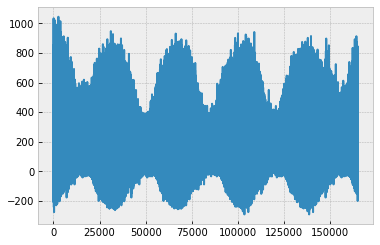

In [35]:
# Data was sampled every 15 minutes, and should have annual and daily trend
daily_period = 4*24
yearly_period = int(daily_period * 365.25)#this is okay because the daily period is divisible by 4

#daily_multiplicative_ds = ConditionalDeseasonalizer(sp=daily_period, model='multiplicative').fit(dt1["SolRad1"])
daily_additive_ds = Deseasonalizer(sp=daily_period, model='additive').fit(dt1["SolRad1"])
#yearly_multiplicative_ds = ConditionalDeseasonalizer(sp=yearly_period, model='multiplicative').fit(dt1["SolRad1"])
yearly_additive_ds = Deseasonalizer(sp=yearly_period, model='additive').fit(dt1["SolRad1"])

plt.plot(yearly_additive_ds.transform(dt1['SolRad1']))


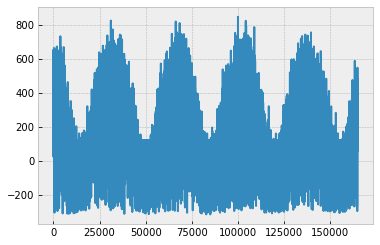

In [33]:
plt.plot(daily_additive_ds.transform(dt1['SolRad1']))

Removing the daily trend really does not make our series look any better - the fact that we have negative values after removing the trend is not a good sign.  Let's assume that this seasonal effect is going to stay if we use this method.  Maybe we are better off using someting else?

I am a big fan of TBATS (I think it does a great job predicting time series) but it's not a great first model.  Let's try using something like ARMA and ARIMA first, and then TBATS and finish with an LSTM Model.

In order to do this, I have to split the data into a train and test set.  This can be a pain for time series (windowing, etc.) but `sktime` makes that easier.

## ARIMA Model.  

In this case, we can start with an (S)ARIMA model.  `sktime`'s implementation of AutoARIMA makes this process much easier, since it automatically includes a grid search for hyperparameters and optimizes the model size using the information criterion of your choice. I am using the Corrected Akaike Information Criterion (AICC) as with the AIC and BIC gives bad model in this case (models grow too much and fail to converge).  

In order to do this, we split the time series into train and test pieces, initialize the model, fit it to the data, and calculate some predictions.

In [9]:
y_train, y_test = temporal_train_test_split(dt1['SolRad1'] )

In [ ]:
naive_model = NaiveForecaster()
naive_model.fit(y_train)
naive_prediction = naive_model.predict(y_test)

naive_loss = smape_loss(y_test, naive_prediction)

In [105]:
# Data was sampled every 15 minutes, and should have annual and daily trend
daily_period = 4*24
yearly_period = daily_period * 365.242

arima_model = AutoARIMA(start_p=4, start_q=4, max_p=10, max_q=10,information_criterion='aicc')
arima_model.fit(y_train)

C:\Users\kenne\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kenne\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kenne\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kenne\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AutoARIMA(information_criterion='aicc', max_p=10, max_q=10, start_p=4,
          start_q=4)

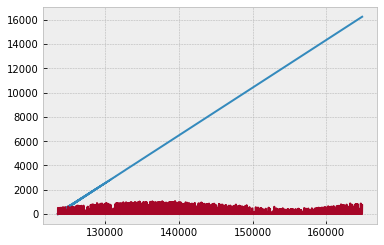

In [106]:
# Currently, AutoARIMA.predict() is broken; it can only predict one time step in advance; the type of forecast horizon is usable.  

arima_prediction = arima_model.predict(fh=[i+1 for i in range(0,y_test.size)])
plt.plot(arima_prediction)
plt.plot(y_test)
plt.show()

#arima_prediction.index = y_test.index
arima_loss = smape_loss(y_test, arima_prediction)



## TBATS

TBATS is my personal favorate time series model (also a big fan of the Hilbert-Huang Transform, but that's for another time).  I tend to overuse TBATS n all likelihood, but no matter.  

In [107]:
# create model and fit it to the data
tbats_model = TBATS(seasonal_periods=[daily_period,yearly_period])
tbats_model.fit(dt1["SolRad1"])

y_forecast = tbats_model.forecast(y_test.size)

tbats_loss = smape_loss(y_test, tbats_forecast)

plot_ys(y_forecast)

## Comparison of Predictions

So far, we have ARIMA, TBATS, and a naive forecast.  Let's have a Comparison of the results:

In [ ]:
print(f'Naive Loss: {naive_loss} \nARIMA Model Loss: {arima_loss} \nTBATS Model Loss: {tbats_loss}')

## Deep Learning Model

These look fine (I guess), but these periods of zeros make these models ill suited.  For this reason, we might be better off with a deep learning approach.  The Universal Approximation Theorem says we should be able to learn any function, so something that is zero a lot should actually be easy.  For that reason, we will give an LSTM model a go.  

In order to so this, we will use 

## Data Preparation

Let's fit prepare the data for forecasting.  `sktime` uses `pandas.Series` objects for its data, so working with our data did not take much preparation.  Moving to TensorFlow, we need to do a little work.  

This preparation pipeline will look like this:

1. Split the data into train and test

2. Standardize the data (move to mean 0 and variance 1)

3. Convert the data to Tensors


In [40]:
# The basis for this function comes from the TensorFlow website, so I cannot take credit for it.  I did tweak it a little for this context.

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [39]:
# Initial parameters for prediction
DATASPLIT_TRAIN = int(np.floor(0.8*31189))
DATASPLIT_VAL = DATASPLIT_TRAIN + int(np.floor(0.1*31189))
DATASPLIT_TEST = DATASPLIT_VAL + int(np.floor(0.1*31189))
HISTORYLENGTH = 4 * 24 * 7
PREDICTIONLENGTH = 4

# Clean NaN values (2?)
dt1.dropna(inplace=True)


# Select Data Column for initial pass
solRad = dt1['SolRad1'].squeeze()
solRad.index = dt1['Date'].squeeze()



print('SolRad Variable size: ', solRad.shape)

solRad = solRad.values
print('SolRad Variable size: ', solRad.shape)


# standardize data using train set
solRad_mean = solRad[:DATASPLIT_TRAIN].mean()
solRad_std = solRad[:DATASPLIT_TRAIN].std()

stRad = (solRad - solRad_mean) / solRad_std

# prep the data and split into train / test
xTrain, yTrain = univariate_data(stRad,0,DATASPLIT_TRAIN,HISTORYLENGTH,PREDICTIONLENGTH)

xTest, yTest = univariate_data(stRad,DATASPLIT_TRAIN+1,None,HISTORYLENGTH,PREDICTIONLENGTH)

print('xTrain Variable size', xTrain.shape)

SolRad Variable size:  (164833,)
SolRad Variable size:  (164833,)


NameError: name 'univariate_data' is not defined

In [32]:
SolRad_train = solRad[:DATASPLIT_TRAIN]
SolRad_val = solRad[DATASPLIT_TRAIN:DATASPLIT_VAL]
SolRad_val = solRad[DATASPLIT_VAL:]



In [33]:
BATCHSIZE = 64
BUFFERSIZE = 5000
EPOCHS = 40
N_TRAIN_SEQ = 24279
ITERATIONS = N_TRAIN_SEQ // BATCHSIZE

trainingData = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
trainingData = trainingData.cache().shuffle(BUFFERSIZE).batch(BATCHSIZE).repeat()

testData = tf.data.Dataset.from_tensor_slices((xTest, yTest))
testData = testData.batch(BATCHSIZE).repeat()

print(trainingData)
print(testData)

<RepeatDataset shapes: ((None, 672, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 672, 1), (None,)), types: (tf.float64, tf.float64)>


### Model Compilation

Let's compile the model.  This one is pretty small since we want to keep the training time and model power usage down.  

The architecture is a three layer LSTM network.  

In [37]:
# compile the model (functional API)
ts_input = keras.Input(shape = (HISTORYLENGTH,1))
x=keras.layers.LSTM(units=HISTORYLENGTH,return_sequences=True)(ts_input)
x = keras.layers.LSTM(units=int(np.floor(HISTORYLENGTH/2)),return_sequences=True)(x)
x = keras.layers.LSTM(units=int(np.floor(HISTORYLENGTH/4)),return_sequences=True)(x)
outputs = keras.layers.LSTM(units=1)(x)

lstmModel = keras.Model(inputs = ts_input, outputs = outputs)
adamOpt = keras.optimizers.Adam(lr=0.0005)

lstmModel.compile(optimizer = adamOpt, loss = 'mse', metrics = ['mae','mse'])

lstmModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 672, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 672, 672)          1811712   
_________________________________________________________________
lstm_1 (LSTM)                (None, 672, 336)          1356096   
_________________________________________________________________
lstm_2 (LSTM)                (None, 672, 168)          339360    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 680       
Total params: 3,507,848
Trainable params: 3,507,848
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Weights and Biases logging; you can skip this if you don't have an account
import wandb
from wandb.keras import WandbCallback
WANDB_NOTEBOOK_NAME = 'Solar Radiation Prediction'
wandb.init(project=WANDB_NOTEBOOK_NAME)

# Note: This WandbCallback is initialized in model.fit


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## More Preparation for training

Let's define some checkpoints for saving the model and save everything to Weights & Biases

In [36]:
# Save the model periodically
checkpointPath = "checkpoints/cp.ckpt"
checkpointDirectory = os.path.dirname(checkpointPath)

cp_callback = keras.callbacks.ModelCheckpoint(filepath = checkpointDirectory, save_weights_only = True, verbose = 1)

In [38]:
%%wandb
#Train Model and show results w/ W&B
lstmModel.fit(trainingData,epochs = EPOCHS, steps_per_epoch = ITERATIONS, verbose=0, validation_data=testData,validation_steps=20,callbacks = [WandbCallback(), cp_callback])#with results to Weights and Biases; replace with Tensorboard / TensorboardColab callback if needed

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
requests_with_retry encountered retryable exception: ('Connection aborted.', TimeoutError(10060, 'A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond', None, 10060, None)). args: ('https://api.wandb.ai/files/krbundy/SolarRadiationPrediction/3k3hqo0p/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 67, 'content': ['{"system.cpu": 53.42, "system.memory": 78.79, "system.disk": 90.8, "system.proc.memory.availableMB": 2569.89, "system.proc.memory.rssMB": 1920.9, "system.proc.memory.percent": 15.85, "system.proc.cpu.threads": 61.0, "system.network.sent": 5665996, "system.network.recv": 4910990, "_wandb": true, "_timestamp": 15

In [16]:
def show_plot(time_series, actual, predicted, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['-', 'rx', 'go']
  #time_steps = create_time_steps(plot_data[0].shape[0])
  #fig,ax = plt.subplots
  nPts = time_series.size
  plt.title(title)
  plt.plot(nPts, actual, marker[1], markersize=10,label=labels[1])
  plt.plot(nPts, predicted, marker[2], markersize=10,label=labels[2])
  plt.plot(np.array(range(nPts)).reshape((nPts,)), time_series.reshape((time_series.size,)), marker[0], label=labels[0])
  plt.legend()
  plt.xlim([0, nPts+2])
  plt.xlabel('Time-Step')
  return plt

def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
show_plot(xTrain[0], yTrain[0], 3.5, 'Sample Example')

NameError: name 'xTrain' is not defined

In [18]:
#lstmModel.summary()
predictionResiduals = np.array([],dtype = np.float32)

for x,y in testData.take(1):
    #print(f'The shape of the first input is {x.numpy().shape}')
    #print(f'The prediction is {lstmModel.predict(x)}\n')
    #print(f'The shape of y {y.shape}')
    yPred = lstmModel.predict(x)[0]
    plot = show_plot(x.numpy()[0],y[0].numpy(),yPred,'Small LSTM Model')
    resid = y[0] - yPred
    predictionResiduals = np.append(predictionResiduals,resid)
    plot.show()

NameError: name 'np' is not defined

In [19]:
lstmModel.save('saved2LSTMModel')

NameError: name 'lstmModel' is not defined

In [20]:
lstm_results = lstmModel.evaluate(testData, batch_size=128)

lstm_loss = smape_loss(y_test, lstm_results)

NameError: name 'lstmModel' is not defined

## Conclusion

Let's take a look at the final results for the models:

In [ ]:
print(f'Naive Loss: {naive_loss} \nARIMA Model Loss: {arima_loss} \nTBATS Model Loss: {tbats_loss} \n LSTM Model Loss: {lstm_loss}')

So it looks like we have a winner!  